In [1]:
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer

import torch

/home/karvsmech/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initiating the model and the tokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)


def extract_hidden_states(batch):
    # place model inputs on the GPU
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        return {'hidden_state': last_hidden_state[:, 0]}

In [4]:
# loading emotion dataset and tokenizing
emotion = load_dataset('emotion')
emotion_encoded = emotion.map(tokenize, batched=True, batch_size=None)
emotion_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_hidden = emotion_encoded.map(extract_hidden_states, batched=True)

In [5]:
# creating a feature matrix
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_valid = np.array(emotions_hidden['validation']['label'])

In [6]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [7]:
print(np.max(X_train))
print(np.min(X_train))

4.029681
-8.671626


In [8]:
# umap works best when the input values are between [0, 1]
X_scaled = MinMaxScaler().fit_transform(X_train)

In [9]:
print(np.max(X_scaled))
print(np.min(X_scaled))

1.0000001
0.0


In [10]:
import pandas as pd

# initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# create a dataframe of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.322739,6.954739,0
1,-3.322717,5.906458,0
2,5.226510,3.543206,3
3,-2.340036,3.970728,2
4,-3.433022,3.912760,3


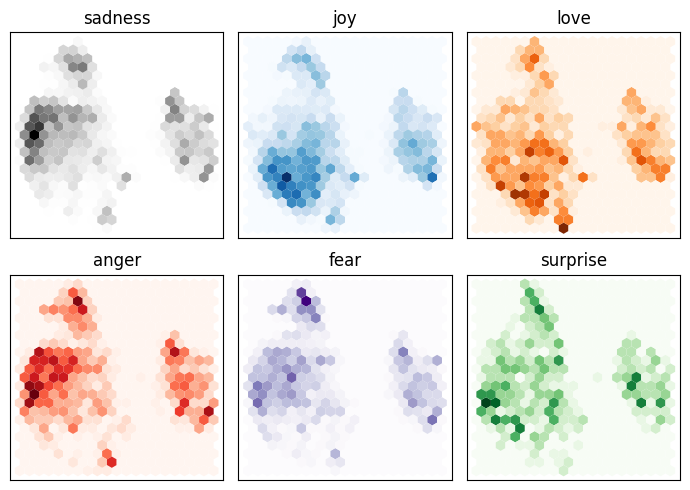

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotion['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

In [13]:
# TODO train a neural network classifier here.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6345

In [29]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

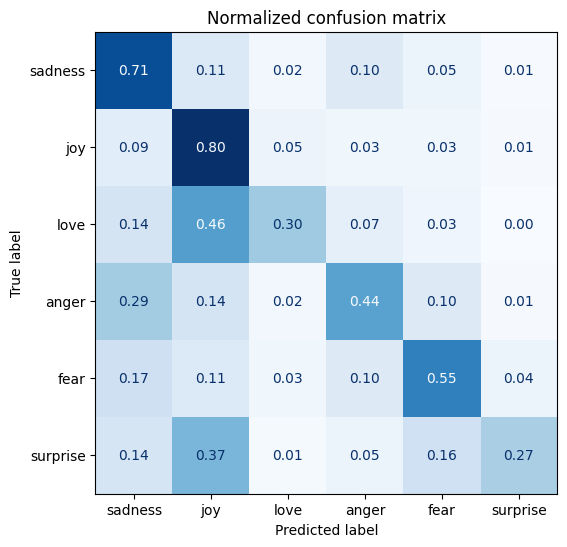

In [37]:
# plotting a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(cmap='Blues', ax=ax, values_format='.2f', colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)